In [30]:
import pandas as pd

# Load datasets
transactions_file = "transactions_data.csv"
products_file = "products_data.csv"
customers_file = "customers_data.csv"

transactions_data = pd.read_csv(transactions_file)
products_data = pd.read_csv(products_file)
customers_data = pd.read_csv(customers_file)


# Clean Products Data

# Remove 'Php' and commas, but keep NaN for missing Product_Price
products_data['Product_Price'] = (
    products_data['Product_Price']
    .astype(str)
    .str.replace(r'[^\d.]', '', regex=True)  # Remove non-numeric characters
    .replace('', pd.NA)  # Keep NaN where price was missing
    .astype(float)
)

# Ensure Product_ID is numeric but keep NaN for missing values
products_data["Product_ID"] = pd.to_numeric(products_data["Product_ID"], errors='coerce')


# Clean Transactions Data

# Drop unnecessary 'Unnamed: 0' column if it exists
transactions_data = transactions_data.loc[:, ~transactions_data.columns.str.contains('^Unnamed')]

# Ensure Transaction_ID is unique and fill missing ones
transactions_data["Transaction_ID"] = pd.to_numeric(transactions_data["Transaction_ID"], errors='coerce')

# Keep Transaction_Date as NaN where missing
transactions_data["Transaction_Date"] = pd.to_datetime(transactions_data["Transaction_Date"], errors="coerce")

# Ensure Product_ID is numeric but keep NaN for missing values
transactions_data["Product_ID"] = pd.to_numeric(transactions_data["Product_ID"], errors='coerce')

# Keep Quantity as NaN if missing
transactions_data["Quantity"] = pd.to_numeric(transactions_data["Quantity"], errors='coerce')

# Keep Product_Price as NaN where missing
transactions_data["Product_Price"] = pd.to_numeric(transactions_data["Product_Price"], errors='coerce')

# **Fix Company_ID Data Type Before Merging**
transactions_data["Company_ID"] = transactions_data["Company_ID"].astype(str)

# Merge transactions with products
transactions_data = transactions_data.merge(products_data, on="Product_ID", how="left")

# Prioritize Transaction Product_Price over Products Data Product_Price
transactions_data["Product_Price"] = transactions_data["Product_Price_x"].combine_first(transactions_data["Product_Price_y"])

# Drop unnecessary columns
transactions_data.drop(columns=["Product_Price_x", "Product_Price_y"], inplace=True, errors="ignore")

# Keep Revenue_per_Transaction as NaN if price or quantity is missing
transactions_data["Revenue_per_Transaction"] = transactions_data["Quantity"] * transactions_data["Product_Price"]


# Clean Customers Data

# Standardize 'Company_Name'
customers_data["Company_Name"] = customers_data["Company_Name"].str.strip()

# Keep Company_Profit as NaN if missing
customers_data["Company_Profit"] = pd.to_numeric(customers_data["Company_Profit"], errors='coerce')

# **Fix Company_ID Data Type Before Merging**
customers_data["Company_ID"] = customers_data["Company_ID"].astype(str)


# Merge Transactions with Customers

merged_data = pd.merge(transactions_data, customers_data, on="Company_ID", how="left")

# Drop unnecessary columns
merged_data.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)


# Save Cleaned Datasets

transactions_data.to_csv("cleaned_transactions_data.csv", index=False)
products_data.to_csv("cleaned_products_data.csv", index=False)
customers_data.to_csv("cleaned_customers_data.csv", index=False)
merged_data.to_csv("merged_data.csv", index=False)

# Validate final missing values
missing_summary = merged_data.isnull().sum()
print("Missing Values per Column:\n", missing_summary)

print("Data Cleaning Completed: Missing values for dates, price, and revenue are kept as NaN!")


Missing Values per Column:
 Transaction_ID              2090
Company_ID                     0
Product_ID                  3674
Quantity                    2102
Transaction_Date           15495
Total_Cost                  1942
Product_Name                1641
Product_Price                175
Revenue_per_Transaction     2256
Company_Name                 970
Company_Profit              3163
Address                      970
dtype: int64
🚀 Data Cleaning Completed: Missing values for dates, price, and revenue are kept as NaN!


Model Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        18

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



C:\Users\bmore\AppData\Local\Temp\ipykernel_3964\1574611928.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data["First_Transaction_Date"].fillna(min_transaction_date, inplace=True)


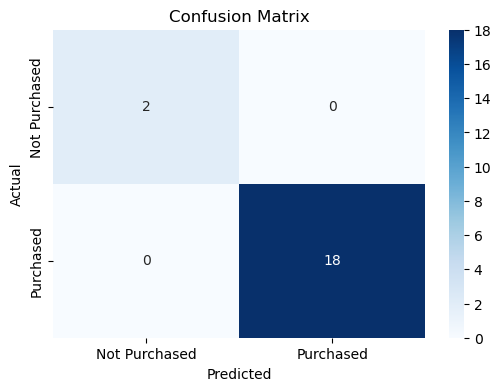

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Load the cleaned datasets

customers_df = pd.read_csv("cleaned_customers_data.csv")
transactions_df = pd.read_csv("cleaned_transactions_data.csv")


# Convert Transaction_Date to Datetime Properly

transactions_df["Transaction_Date"] = pd.to_datetime(transactions_df["Transaction_Date"], errors="coerce")


# Aggregate Transactions at the Customer Level

customer_transactions = transactions_df.groupby("Company_ID").agg(
    Total_Spend=("Revenue_per_Transaction", "sum"),
    Total_Transactions=("Transaction_ID", "count"),
    Avg_Spend=("Revenue_per_Transaction", "mean"),
    First_Transaction_Date=("Transaction_Date", lambda x: x.min(skipna=True))  # Ensure min() only runs on valid dates
).reset_index()


# Merge transactions with customer demographics

customer_data = customers_df.merge(customer_transactions, on="Company_ID", how="left")

# Fill missing values with 0 for numerical features
customer_data.fillna({"Total_Spend": 0, "Total_Transactions": 0, "Avg_Spend": 0}, inplace=True)


# Convert Dates to Numeric Format

# Replace missing dates with the earliest available date
customer_data["First_Transaction_Date"] = pd.to_datetime(customer_data["First_Transaction_Date"], errors="coerce")
min_transaction_date = customer_data["First_Transaction_Date"].min(skipna=True)
customer_data["First_Transaction_Date"].fillna(min_transaction_date, inplace=True)

# Convert to numeric: Days since first transaction
customer_data["Days_Since_First_Transaction"] = (customer_data["First_Transaction_Date"] - min_transaction_date).dt.days

# Drop the original date column
customer_data.drop(columns=["First_Transaction_Date"], inplace=True)


# Define Target Variable

# Create a binary target variable: If the customer made at least one transaction, they are a buyer.
customer_data["Purchased"] = (customer_data["Total_Transactions"] > 0).astype(int)


# Select Features for Training

# Keep only numerical features
features = ["Company_Profit", "Total_Spend", "Total_Transactions", "Avg_Spend", "Days_Since_First_Transaction"]
target = "Purchased"

X = customer_data[features]
y = customer_data[target]

# ** Fix NaN Issue: Impute Missing Values in X**
imputer = SimpleImputer(strategy="median")  # Use median imputation
X = imputer.fit_transform(X)

# Standardizing numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split Data into Training & Testing Sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Train Logistic Regression Model

log_model = LogisticRegression()
log_model.fit(X_train, y_train)


# Make Predictions & Evaluate Model

y_pred = log_model.predict(X_test)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Not Purchased", "Purchased"], yticklabels=["Not Purchased", "Purchased"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
